<a href="https://colab.research.google.com/github/ester0926/Deep-Generative-Models/blob/main/%E4%BD%9C%E6%A5%AD2_%E6%AF%94%E8%BC%83_VAE%E3%80%81GAN%E3%80%81cGAN_%E8%88%87_Diffusion_Model_%E5%9C%A8_MNIST_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E7%94%9F%E6%88%90%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-10-03 04:45:34--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.4.100, 142.250.4.138, 142.250.4.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-10-03 04:45:34--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-10-03 04:45:36 (

In [ ]:
# 前置設定
# 匯入必要套件
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random, time
from tqdm import tqdm
import torchvision
import torchvision.utils as vutils

# 設定隨機種子以確保可重現性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 裝置設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超參數
batch_size = 128
image_size = 28
channels = 1
latent_dim = 20  # 用於 VAE
noise_dim = 100  # 用於 GAN 和 cGAN
num_classes = 10  # 用於 cGAN
epochs_vae = 100
epochs_gan = 100
epochs_cgan = 100
epochs_diffusion = 150  # Diffusion 需要更多 epochs
lr_vae = 1e-3
lr_gan = 2e-4
lr_cgan = 2e-4
lr_diffusion = 2e-4
beta1 = 0.5  # 用於 GAN 的 Adam
patience = 10  # 早停耐心值

# 資料載入
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# train/valid split
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# 顯示影像的函數
def show_images(images, title, nrow=10):
    grid = vutils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.02MB/s]


# VAE

訓練 VAE...


100%|██████████| 375/375 [00:13<00:00, 28.45it/s]


VAE Epoch 1/100, Loss: 1.4917 | Val: 1.1244 | Time: 15.67s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.10it/s]


VAE Epoch 2/100, Loss: 1.0215 | Val: 0.9464 | Time: 14.12s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 31.95it/s]


VAE Epoch 3/100, Loss: 0.9130 | Val: 0.8938 | Time: 14.70s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.49it/s]


VAE Epoch 4/100, Loss: 0.8727 | Val: 0.8630 | Time: 15.05s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.60it/s]


VAE Epoch 5/100, Loss: 0.8529 | Val: 0.8495 | Time: 13.83s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.25it/s]


VAE Epoch 6/100, Loss: 0.8409 | Val: 0.8392 | Time: 14.05s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.16it/s]


VAE Epoch 7/100, Loss: 0.8323 | Val: 0.8333 | Time: 14.03s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.63it/s]


VAE Epoch 8/100, Loss: 0.8259 | Val: 0.8317 | Time: 14.80s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 33.33it/s]


VAE Epoch 9/100, Loss: 0.8206 | Val: 0.8264 | Time: 14.34s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.42it/s]


VAE Epoch 10/100, Loss: 0.8169 | Val: 0.8208 | Time: 13.92s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.45it/s]


VAE Epoch 11/100, Loss: 0.8127 | Val: 0.8199 | Time: 13.89s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.49it/s]


VAE Epoch 12/100, Loss: 0.8086 | Val: 0.8160 | Time: 13.88s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.36it/s]


VAE Epoch 13/100, Loss: 0.8063 | Val: 0.8120 | Time: 13.94s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.41it/s]


VAE Epoch 14/100, Loss: 0.8038 | Val: 0.8111 | Time: 13.94s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.29it/s]


VAE Epoch 15/100, Loss: 0.8013 | Val: 0.8077 | Time: 14.51s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 33.14it/s]


VAE Epoch 16/100, Loss: 0.7989 | Val: 0.8075 | Time: 14.10s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.42it/s]


VAE Epoch 17/100, Loss: 0.7974 | Val: 0.8059 | Time: 13.92s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.23it/s]


VAE Epoch 18/100, Loss: 0.7954 | Val: 0.8031 | Time: 13.98s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.28it/s]


VAE Epoch 19/100, Loss: 0.7944 | Val: 0.8036 | Time: 13.99s


100%|██████████| 375/375 [00:11<00:00, 32.24it/s]


VAE Epoch 20/100, Loss: 0.7926 | Val: 0.8027 | Time: 13.98s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 31.87it/s]


VAE Epoch 21/100, Loss: 0.7914 | Val: 0.8011 | Time: 14.44s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.80it/s]


VAE Epoch 22/100, Loss: 0.7901 | Val: 0.8002 | Time: 14.38s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.99it/s]


VAE Epoch 23/100, Loss: 0.7889 | Val: 0.7987 | Time: 14.87s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.55it/s]


VAE Epoch 24/100, Loss: 0.7876 | Val: 0.7978 | Time: 13.86s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.20it/s]


VAE Epoch 25/100, Loss: 0.7869 | Val: 0.8009 | Time: 14.10s


100%|██████████| 375/375 [00:11<00:00, 32.50it/s]


VAE Epoch 26/100, Loss: 0.7852 | Val: 0.7954 | Time: 13.95s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.29it/s]


VAE Epoch 27/100, Loss: 0.7847 | Val: 0.7990 | Time: 14.53s


100%|██████████| 375/375 [00:11<00:00, 32.55it/s]


VAE Epoch 28/100, Loss: 0.7838 | Val: 0.7948 | Time: 14.28s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.53it/s]


VAE Epoch 29/100, Loss: 0.7829 | Val: 0.7955 | Time: 13.96s


100%|██████████| 375/375 [00:11<00:00, 32.26it/s]


VAE Epoch 30/100, Loss: 0.7821 | Val: 0.7918 | Time: 13.95s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.34it/s]


VAE Epoch 31/100, Loss: 0.7811 | Val: 0.7941 | Time: 13.94s


100%|██████████| 375/375 [00:11<00:00, 32.25it/s]


VAE Epoch 32/100, Loss: 0.7802 | Val: 0.7946 | Time: 13.95s


100%|██████████| 375/375 [00:11<00:00, 32.78it/s]


VAE Epoch 33/100, Loss: 0.7794 | Val: 0.7939 | Time: 14.02s


100%|██████████| 375/375 [00:11<00:00, 32.81it/s]


VAE Epoch 34/100, Loss: 0.7791 | Val: 0.7921 | Time: 14.40s


100%|██████████| 375/375 [00:11<00:00, 32.71it/s]


VAE Epoch 35/100, Loss: 0.7786 | Val: 0.7918 | Time: 13.79s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.64it/s]


VAE Epoch 36/100, Loss: 0.7771 | Val: 0.7926 | Time: 13.94s


100%|██████████| 375/375 [00:11<00:00, 32.24it/s]


VAE Epoch 37/100, Loss: 0.7769 | Val: 0.7897 | Time: 13.98s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.77it/s]


VAE Epoch 38/100, Loss: 0.7764 | Val: 0.7917 | Time: 14.64s


100%|██████████| 375/375 [00:11<00:00, 32.38it/s]


VAE Epoch 39/100, Loss: 0.7752 | Val: 0.7892 | Time: 14.19s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 33.27it/s]


VAE Epoch 40/100, Loss: 0.7750 | Val: 0.7905 | Time: 14.31s


100%|██████████| 375/375 [00:15<00:00, 24.12it/s]


VAE Epoch 41/100, Loss: 0.7740 | Val: 0.7879 | Time: 17.88s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.08it/s]


VAE Epoch 42/100, Loss: 0.7742 | Val: 0.7891 | Time: 14.04s


100%|██████████| 375/375 [00:11<00:00, 32.72it/s]


VAE Epoch 43/100, Loss: 0.7734 | Val: 0.7909 | Time: 13.94s


100%|██████████| 375/375 [00:11<00:00, 32.95it/s]


VAE Epoch 44/100, Loss: 0.7729 | Val: 0.7878 | Time: 14.46s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 31.44it/s]


VAE Epoch 45/100, Loss: 0.7722 | Val: 0.7887 | Time: 14.26s


100%|██████████| 375/375 [00:11<00:00, 32.03it/s]


VAE Epoch 46/100, Loss: 0.7721 | Val: 0.7892 | Time: 14.09s


100%|██████████| 375/375 [00:11<00:00, 32.99it/s]


VAE Epoch 47/100, Loss: 0.7715 | Val: 0.7869 | Time: 13.71s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.76it/s]


VAE Epoch 48/100, Loss: 0.7714 | Val: 0.7888 | Time: 13.77s


100%|██████████| 375/375 [00:11<00:00, 32.64it/s]


VAE Epoch 49/100, Loss: 0.7703 | Val: 0.7900 | Time: 13.78s


100%|██████████| 375/375 [00:11<00:00, 32.80it/s]


VAE Epoch 50/100, Loss: 0.7702 | Val: 0.7886 | Time: 14.27s


100%|██████████| 375/375 [00:11<00:00, 33.45it/s]


VAE Epoch 51/100, Loss: 0.7700 | Val: 0.7872 | Time: 13.97s


100%|██████████| 375/375 [00:11<00:00, 32.67it/s]


VAE Epoch 52/100, Loss: 0.7694 | Val: 0.7871 | Time: 13.81s


100%|██████████| 375/375 [00:12<00:00, 30.45it/s]


VAE Epoch 53/100, Loss: 0.7684 | Val: 0.7866 | Time: 14.63s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.54it/s]


VAE Epoch 54/100, Loss: 0.7686 | Val: 0.7886 | Time: 13.86s


100%|██████████| 375/375 [00:11<00:00, 32.56it/s]


VAE Epoch 55/100, Loss: 0.7681 | Val: 0.7842 | Time: 13.89s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.72it/s]


VAE Epoch 56/100, Loss: 0.7678 | Val: 0.7850 | Time: 14.07s


100%|██████████| 375/375 [00:11<00:00, 32.93it/s]


VAE Epoch 57/100, Loss: 0.7676 | Val: 0.7846 | Time: 14.27s


100%|██████████| 375/375 [00:11<00:00, 32.64it/s]


VAE Epoch 58/100, Loss: 0.7670 | Val: 0.7851 | Time: 13.81s


100%|██████████| 375/375 [00:11<00:00, 32.58it/s]


VAE Epoch 59/100, Loss: 0.7664 | Val: 0.7860 | Time: 13.87s


100%|██████████| 375/375 [00:11<00:00, 32.45it/s]


VAE Epoch 60/100, Loss: 0.7667 | Val: 0.7839 | Time: 13.87s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.55it/s]


VAE Epoch 61/100, Loss: 0.7663 | Val: 0.7862 | Time: 13.88s


100%|██████████| 375/375 [00:11<00:00, 32.40it/s]


VAE Epoch 62/100, Loss: 0.7656 | Val: 0.7885 | Time: 13.92s


100%|██████████| 375/375 [00:11<00:00, 32.86it/s]


VAE Epoch 63/100, Loss: 0.7654 | Val: 0.7848 | Time: 14.45s


100%|██████████| 375/375 [00:11<00:00, 33.22it/s]


VAE Epoch 64/100, Loss: 0.7655 | Val: 0.7855 | Time: 13.93s


100%|██████████| 375/375 [00:11<00:00, 32.68it/s]


VAE Epoch 65/100, Loss: 0.7645 | Val: 0.7846 | Time: 13.77s


100%|██████████| 375/375 [00:11<00:00, 32.42it/s]


VAE Epoch 66/100, Loss: 0.7643 | Val: 0.7838 | Time: 13.93s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.02it/s]


VAE Epoch 67/100, Loss: 0.7643 | Val: 0.7834 | Time: 14.07s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.41it/s]


VAE Epoch 68/100, Loss: 0.7639 | Val: 0.7845 | Time: 14.62s


100%|██████████| 375/375 [00:11<00:00, 32.17it/s]


VAE Epoch 69/100, Loss: 0.7636 | Val: 0.7837 | Time: 14.66s


100%|██████████| 375/375 [00:11<00:00, 33.37it/s]


VAE Epoch 70/100, Loss: 0.7632 | Val: 0.7824 | Time: 13.90s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.60it/s]


VAE Epoch 71/100, Loss: 0.7629 | Val: 0.7834 | Time: 13.86s


100%|██████████| 375/375 [00:11<00:00, 32.36it/s]


VAE Epoch 72/100, Loss: 0.7625 | Val: 0.7835 | Time: 14.00s


100%|██████████| 375/375 [00:11<00:00, 32.60it/s]


VAE Epoch 73/100, Loss: 0.7624 | Val: 0.7850 | Time: 13.80s


100%|██████████| 375/375 [00:11<00:00, 32.38it/s]


VAE Epoch 74/100, Loss: 0.7623 | Val: 0.7828 | Time: 13.91s


100%|██████████| 375/375 [00:11<00:00, 32.41it/s]


VAE Epoch 75/100, Loss: 0.7623 | Val: 0.7835 | Time: 14.24s


100%|██████████| 375/375 [00:11<00:00, 33.15it/s]


VAE Epoch 76/100, Loss: 0.7618 | Val: 0.7825 | Time: 14.22s


100%|██████████| 375/375 [00:11<00:00, 32.23it/s]


VAE Epoch 77/100, Loss: 0.7618 | Val: 0.7810 | Time: 13.96s
儲存最佳模型


100%|██████████| 375/375 [00:11<00:00, 32.38it/s]


VAE Epoch 78/100, Loss: 0.7612 | Val: 0.7854 | Time: 13.93s


100%|██████████| 375/375 [00:11<00:00, 32.53it/s]


VAE Epoch 79/100, Loss: 0.7613 | Val: 0.7831 | Time: 13.85s


100%|██████████| 375/375 [00:11<00:00, 32.66it/s]


VAE Epoch 80/100, Loss: 0.7607 | Val: 0.7837 | Time: 13.84s


100%|██████████| 375/375 [00:11<00:00, 32.25it/s]


VAE Epoch 81/100, Loss: 0.7607 | Val: 0.7820 | Time: 14.01s


100%|██████████| 375/375 [00:11<00:00, 31.81it/s]


VAE Epoch 82/100, Loss: 0.7603 | Val: 0.7832 | Time: 15.08s


100%|██████████| 375/375 [00:11<00:00, 32.07it/s]


VAE Epoch 83/100, Loss: 0.7600 | Val: 0.7809 | Time: 14.18s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.60it/s]


VAE Epoch 84/100, Loss: 0.7601 | Val: 0.7817 | Time: 14.62s


100%|██████████| 375/375 [00:11<00:00, 32.17it/s]


VAE Epoch 85/100, Loss: 0.7598 | Val: 0.7823 | Time: 14.03s


100%|██████████| 375/375 [00:11<00:00, 32.61it/s]


VAE Epoch 86/100, Loss: 0.7596 | Val: 0.7830 | Time: 13.86s


100%|██████████| 375/375 [00:11<00:00, 31.96it/s]


VAE Epoch 87/100, Loss: 0.7589 | Val: 0.7831 | Time: 14.42s


100%|██████████| 375/375 [00:11<00:00, 32.16it/s]


VAE Epoch 88/100, Loss: 0.7595 | Val: 0.7838 | Time: 14.54s


100%|██████████| 375/375 [00:11<00:00, 31.80it/s]


VAE Epoch 89/100, Loss: 0.7590 | Val: 0.7810 | Time: 14.21s


100%|██████████| 375/375 [00:11<00:00, 32.01it/s]


VAE Epoch 90/100, Loss: 0.7584 | Val: 0.7814 | Time: 14.09s


100%|██████████| 375/375 [00:11<00:00, 31.97it/s]


VAE Epoch 91/100, Loss: 0.7582 | Val: 0.7821 | Time: 14.09s


100%|██████████| 375/375 [00:11<00:00, 31.79it/s]


VAE Epoch 92/100, Loss: 0.7585 | Val: 0.7832 | Time: 14.22s


100%|██████████| 375/375 [00:11<00:00, 32.24it/s]


VAE Epoch 93/100, Loss: 0.7582 | Val: 0.7842 | Time: 14.37s
早停觸發
總訓練時間: 1319.10s


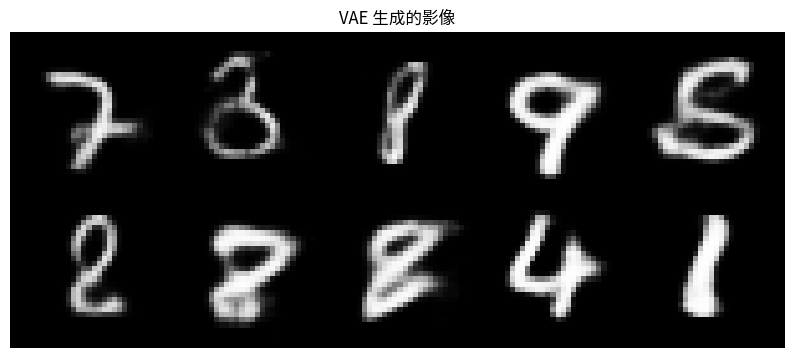

In [ ]:
# VAE 模型 - 升級為 CNN 版本
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE 損失函數
def vae_loss(recon_x, x, mu, logvar):
    target = (x + 1) / 2
    BCE = F.binary_cross_entropy(recon_x, target, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 初始化模型
vae = VAE().to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=lr_vae)

# 訓練 VAE
def vae_loss_batch(x):
    recon_batch, mu, logvar = vae(x)
    loss = vae_loss(recon_batch, x, mu, logvar)
    return loss / x.size(0)  # 平均損失

best_val = float('inf')
early = 0
best_model_path = "vae_best.pth"
train_losses, valid_losses = [], []

print("訓練 VAE...")
total_start = time.time()
for epoch in range(1, epochs_vae + 1):
    ep_start = time.time()
    vae.train()
    train_loss_sum = 0.0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        loss = vae_loss_batch(data)
        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()
        train_loss_sum += loss.item()
    avg_train = train_loss_sum / len(train_loader.dataset)
    train_losses.append(avg_train)

    # validation
    vae.eval()
    val_sum = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            val_sum += vae_loss_batch(data).item()
    avg_val = val_sum / len(valid_loader.dataset)
    valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"VAE Epoch {epoch}/{epochs_vae}, Loss: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(vae.state_dict(), best_model_path)
        print("儲存最佳模型")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("早停觸發")
            break

total_time = time.time() - total_start
print(f"總訓練時間: {total_time:.2f}s")

# 生成 VAE 影像
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    vae_samples = vae.decode(z)
show_images(vae_samples, "VAE 生成的影像", nrow=5)

# GAN

訓練 GAN...


100%|██████████| 375/375 [00:11<00:00, 31.41it/s]


GAN Epoch 1/100, D Loss: 1.3329, G Loss: 0.8343


100%|██████████| 375/375 [00:11<00:00, 32.28it/s]


GAN Epoch 2/100, D Loss: 1.1033, G Loss: 0.8140


100%|██████████| 375/375 [00:11<00:00, 31.85it/s]


GAN Epoch 3/100, D Loss: 1.1529, G Loss: 0.8451


100%|██████████| 375/375 [00:11<00:00, 32.10it/s]


GAN Epoch 4/100, D Loss: 1.2540, G Loss: 0.9509


100%|██████████| 375/375 [00:11<00:00, 32.20it/s]


GAN Epoch 5/100, D Loss: 1.2740, G Loss: 0.7171


100%|██████████| 375/375 [00:12<00:00, 31.08it/s]


GAN Epoch 6/100, D Loss: 1.1911, G Loss: 0.8415


100%|██████████| 375/375 [00:12<00:00, 30.57it/s]


GAN Epoch 7/100, D Loss: 1.3102, G Loss: 0.6800


100%|██████████| 375/375 [00:12<00:00, 31.18it/s]


GAN Epoch 8/100, D Loss: 1.1892, G Loss: 1.0759


100%|██████████| 375/375 [00:11<00:00, 31.99it/s]


GAN Epoch 9/100, D Loss: 1.2198, G Loss: 0.8625


100%|██████████| 375/375 [00:11<00:00, 32.31it/s]


GAN Epoch 10/100, D Loss: 1.2523, G Loss: 0.6518


100%|██████████| 375/375 [00:11<00:00, 32.16it/s]


GAN Epoch 11/100, D Loss: 1.2421, G Loss: 0.7503


100%|██████████| 375/375 [00:11<00:00, 32.03it/s]


GAN Epoch 12/100, D Loss: 1.2131, G Loss: 0.8655


100%|██████████| 375/375 [00:11<00:00, 31.72it/s]


GAN Epoch 13/100, D Loss: 1.2139, G Loss: 0.6480


100%|██████████| 375/375 [00:11<00:00, 32.18it/s]


GAN Epoch 14/100, D Loss: 1.2111, G Loss: 0.7945


100%|██████████| 375/375 [00:11<00:00, 31.98it/s]


GAN Epoch 15/100, D Loss: 1.2337, G Loss: 0.7715


100%|██████████| 375/375 [00:11<00:00, 32.10it/s]


GAN Epoch 16/100, D Loss: 1.2342, G Loss: 0.9400


100%|██████████| 375/375 [00:11<00:00, 32.08it/s]


GAN Epoch 17/100, D Loss: 1.2892, G Loss: 1.1845


100%|██████████| 375/375 [00:11<00:00, 31.96it/s]


GAN Epoch 18/100, D Loss: 1.2518, G Loss: 0.7347


100%|██████████| 375/375 [00:11<00:00, 31.61it/s]


GAN Epoch 19/100, D Loss: 1.2133, G Loss: 0.7326


100%|██████████| 375/375 [00:11<00:00, 32.00it/s]


GAN Epoch 20/100, D Loss: 1.1846, G Loss: 0.7741


100%|██████████| 375/375 [00:11<00:00, 31.85it/s]


GAN Epoch 21/100, D Loss: 1.1366, G Loss: 0.7817


100%|██████████| 375/375 [00:11<00:00, 31.93it/s]


GAN Epoch 22/100, D Loss: 1.2883, G Loss: 0.5543


100%|██████████| 375/375 [00:11<00:00, 32.12it/s]


GAN Epoch 23/100, D Loss: 1.0110, G Loss: 0.9028


100%|██████████| 375/375 [00:11<00:00, 31.60it/s]


GAN Epoch 24/100, D Loss: 1.2362, G Loss: 0.5764


100%|██████████| 375/375 [00:12<00:00, 30.71it/s]


GAN Epoch 25/100, D Loss: 1.1502, G Loss: 1.1282


100%|██████████| 375/375 [00:11<00:00, 32.16it/s]


GAN Epoch 26/100, D Loss: 1.2002, G Loss: 0.9123


100%|██████████| 375/375 [00:11<00:00, 32.03it/s]


GAN Epoch 27/100, D Loss: 1.0318, G Loss: 1.3005


100%|██████████| 375/375 [00:11<00:00, 32.33it/s]


GAN Epoch 28/100, D Loss: 1.1642, G Loss: 0.7675


100%|██████████| 375/375 [00:11<00:00, 32.10it/s]


GAN Epoch 29/100, D Loss: 1.1752, G Loss: 0.8582


100%|██████████| 375/375 [00:11<00:00, 32.10it/s]


GAN Epoch 30/100, D Loss: 1.2411, G Loss: 1.1449


100%|██████████| 375/375 [00:11<00:00, 32.09it/s]


GAN Epoch 31/100, D Loss: 1.1900, G Loss: 1.0503


100%|██████████| 375/375 [00:11<00:00, 32.44it/s]


GAN Epoch 32/100, D Loss: 1.1905, G Loss: 0.8506


100%|██████████| 375/375 [00:11<00:00, 32.48it/s]


GAN Epoch 33/100, D Loss: 1.1655, G Loss: 0.8107


100%|██████████| 375/375 [00:11<00:00, 32.21it/s]


GAN Epoch 34/100, D Loss: 1.2903, G Loss: 0.6281


100%|██████████| 375/375 [00:11<00:00, 32.66it/s]


GAN Epoch 35/100, D Loss: 1.2285, G Loss: 0.6947


100%|██████████| 375/375 [00:11<00:00, 32.68it/s]


GAN Epoch 36/100, D Loss: 1.1788, G Loss: 0.9287


100%|██████████| 375/375 [00:11<00:00, 32.27it/s]


GAN Epoch 37/100, D Loss: 1.1458, G Loss: 1.0312


100%|██████████| 375/375 [00:11<00:00, 31.70it/s]


GAN Epoch 38/100, D Loss: 1.1745, G Loss: 0.7681


100%|██████████| 375/375 [00:11<00:00, 31.61it/s]


GAN Epoch 39/100, D Loss: 1.2361, G Loss: 1.1739


100%|██████████| 375/375 [00:11<00:00, 31.48it/s]


GAN Epoch 40/100, D Loss: 1.2066, G Loss: 0.7584


100%|██████████| 375/375 [00:11<00:00, 31.65it/s]


GAN Epoch 41/100, D Loss: 1.2159, G Loss: 0.9838


100%|██████████| 375/375 [00:11<00:00, 31.64it/s]


GAN Epoch 42/100, D Loss: 1.2012, G Loss: 1.1274


100%|██████████| 375/375 [00:12<00:00, 29.61it/s]


GAN Epoch 43/100, D Loss: 1.3356, G Loss: 1.2679


100%|██████████| 375/375 [00:11<00:00, 31.81it/s]


GAN Epoch 44/100, D Loss: 1.1493, G Loss: 0.8666


100%|██████████| 375/375 [00:11<00:00, 31.83it/s]


GAN Epoch 45/100, D Loss: 1.2326, G Loss: 0.7940


100%|██████████| 375/375 [00:11<00:00, 32.14it/s]


GAN Epoch 46/100, D Loss: 1.2458, G Loss: 1.0324


100%|██████████| 375/375 [00:11<00:00, 31.97it/s]


GAN Epoch 47/100, D Loss: 1.1374, G Loss: 0.8068


100%|██████████| 375/375 [00:11<00:00, 31.72it/s]


GAN Epoch 48/100, D Loss: 1.2162, G Loss: 0.7851


100%|██████████| 375/375 [00:11<00:00, 32.01it/s]


GAN Epoch 49/100, D Loss: 1.2486, G Loss: 0.8154


100%|██████████| 375/375 [00:11<00:00, 31.71it/s]


GAN Epoch 50/100, D Loss: 1.2452, G Loss: 1.1441


100%|██████████| 375/375 [00:11<00:00, 31.82it/s]


GAN Epoch 51/100, D Loss: 1.2079, G Loss: 0.8184


100%|██████████| 375/375 [00:11<00:00, 31.74it/s]


GAN Epoch 52/100, D Loss: 1.1708, G Loss: 0.7866


100%|██████████| 375/375 [00:11<00:00, 31.64it/s]


GAN Epoch 53/100, D Loss: 1.2403, G Loss: 1.0428


100%|██████████| 375/375 [00:11<00:00, 31.81it/s]


GAN Epoch 54/100, D Loss: 1.1737, G Loss: 0.6597


100%|██████████| 375/375 [00:11<00:00, 31.67it/s]


GAN Epoch 55/100, D Loss: 1.2129, G Loss: 0.8575


100%|██████████| 375/375 [00:11<00:00, 31.76it/s]


GAN Epoch 56/100, D Loss: 1.3139, G Loss: 0.6130


100%|██████████| 375/375 [00:11<00:00, 32.13it/s]


GAN Epoch 57/100, D Loss: 1.2625, G Loss: 0.8429


100%|██████████| 375/375 [00:11<00:00, 31.89it/s]


GAN Epoch 58/100, D Loss: 1.2147, G Loss: 0.7606


100%|██████████| 375/375 [00:11<00:00, 31.95it/s]


GAN Epoch 59/100, D Loss: 1.1924, G Loss: 0.8734


100%|██████████| 375/375 [00:11<00:00, 31.60it/s]


GAN Epoch 60/100, D Loss: 1.1892, G Loss: 0.9710


100%|██████████| 375/375 [00:12<00:00, 29.89it/s]


GAN Epoch 61/100, D Loss: 1.2122, G Loss: 0.9121


100%|██████████| 375/375 [00:11<00:00, 31.77it/s]


GAN Epoch 62/100, D Loss: 1.2064, G Loss: 0.9782


100%|██████████| 375/375 [00:11<00:00, 31.86it/s]


GAN Epoch 63/100, D Loss: 1.1483, G Loss: 0.8458


100%|██████████| 375/375 [00:11<00:00, 31.95it/s]


GAN Epoch 64/100, D Loss: 1.2529, G Loss: 0.6436


100%|██████████| 375/375 [00:11<00:00, 32.43it/s]


GAN Epoch 65/100, D Loss: 1.1983, G Loss: 1.0000


100%|██████████| 375/375 [00:11<00:00, 32.24it/s]


GAN Epoch 66/100, D Loss: 1.1839, G Loss: 0.9613


100%|██████████| 375/375 [00:11<00:00, 32.61it/s]


GAN Epoch 67/100, D Loss: 1.1962, G Loss: 0.8166


100%|██████████| 375/375 [00:11<00:00, 32.93it/s]


GAN Epoch 68/100, D Loss: 1.2079, G Loss: 0.8087


100%|██████████| 375/375 [00:11<00:00, 31.67it/s]


GAN Epoch 69/100, D Loss: 1.2502, G Loss: 1.1218


100%|██████████| 375/375 [00:11<00:00, 32.05it/s]


GAN Epoch 70/100, D Loss: 1.2668, G Loss: 0.9565


100%|██████████| 375/375 [00:11<00:00, 31.91it/s]


GAN Epoch 71/100, D Loss: 1.2284, G Loss: 0.8096


100%|██████████| 375/375 [00:11<00:00, 32.17it/s]


GAN Epoch 72/100, D Loss: 1.2273, G Loss: 0.9193


100%|██████████| 375/375 [00:11<00:00, 31.81it/s]


GAN Epoch 73/100, D Loss: 1.1885, G Loss: 0.8536


100%|██████████| 375/375 [00:11<00:00, 31.49it/s]


GAN Epoch 74/100, D Loss: 1.0835, G Loss: 1.1254


100%|██████████| 375/375 [00:11<00:00, 31.76it/s]


GAN Epoch 75/100, D Loss: 1.2131, G Loss: 1.1255


100%|██████████| 375/375 [00:11<00:00, 31.66it/s]


GAN Epoch 76/100, D Loss: 1.2626, G Loss: 0.7548


100%|██████████| 375/375 [00:11<00:00, 32.13it/s]


GAN Epoch 77/100, D Loss: 1.2176, G Loss: 1.0722


100%|██████████| 375/375 [00:12<00:00, 30.75it/s]


GAN Epoch 78/100, D Loss: 1.1841, G Loss: 0.7902


100%|██████████| 375/375 [00:13<00:00, 28.45it/s]


GAN Epoch 79/100, D Loss: 1.2665, G Loss: 1.1429


100%|██████████| 375/375 [00:12<00:00, 30.26it/s]


GAN Epoch 80/100, D Loss: 1.1801, G Loss: 1.0254


100%|██████████| 375/375 [00:12<00:00, 30.83it/s]


GAN Epoch 81/100, D Loss: 1.2873, G Loss: 1.0736


100%|██████████| 375/375 [00:12<00:00, 30.02it/s]


GAN Epoch 82/100, D Loss: 1.1767, G Loss: 0.8463


100%|██████████| 375/375 [00:12<00:00, 30.44it/s]


GAN Epoch 83/100, D Loss: 1.2144, G Loss: 1.0200


100%|██████████| 375/375 [00:11<00:00, 31.31it/s]


GAN Epoch 84/100, D Loss: 1.2143, G Loss: 0.8058


100%|██████████| 375/375 [00:11<00:00, 31.90it/s]


GAN Epoch 85/100, D Loss: 1.2538, G Loss: 0.9738


100%|██████████| 375/375 [00:11<00:00, 31.67it/s]


GAN Epoch 86/100, D Loss: 1.1986, G Loss: 0.9137


100%|██████████| 375/375 [00:11<00:00, 31.70it/s]


GAN Epoch 87/100, D Loss: 1.2063, G Loss: 0.7584


100%|██████████| 375/375 [00:11<00:00, 31.48it/s]


GAN Epoch 88/100, D Loss: 1.2463, G Loss: 0.6589


100%|██████████| 375/375 [00:12<00:00, 31.15it/s]


GAN Epoch 89/100, D Loss: 1.2174, G Loss: 0.7908


100%|██████████| 375/375 [00:12<00:00, 31.08it/s]


GAN Epoch 90/100, D Loss: 1.2039, G Loss: 0.8246


100%|██████████| 375/375 [00:11<00:00, 31.44it/s]


GAN Epoch 91/100, D Loss: 1.2581, G Loss: 1.0060


100%|██████████| 375/375 [00:11<00:00, 31.51it/s]


GAN Epoch 92/100, D Loss: 1.2114, G Loss: 0.9776


100%|██████████| 375/375 [00:11<00:00, 31.67it/s]


GAN Epoch 93/100, D Loss: 1.1843, G Loss: 0.9083


100%|██████████| 375/375 [00:12<00:00, 31.13it/s]


GAN Epoch 94/100, D Loss: 1.2490, G Loss: 0.6689


100%|██████████| 375/375 [00:11<00:00, 31.28it/s]


GAN Epoch 95/100, D Loss: 1.2923, G Loss: 1.0689


100%|██████████| 375/375 [00:12<00:00, 29.47it/s]


GAN Epoch 96/100, D Loss: 1.1529, G Loss: 0.7863


100%|██████████| 375/375 [00:11<00:00, 31.81it/s]


GAN Epoch 97/100, D Loss: 1.1646, G Loss: 1.0385


100%|██████████| 375/375 [00:11<00:00, 32.00it/s]


GAN Epoch 98/100, D Loss: 1.2024, G Loss: 0.9425


100%|██████████| 375/375 [00:11<00:00, 31.64it/s]


GAN Epoch 99/100, D Loss: 1.2613, G Loss: 0.8584


100%|██████████| 375/375 [00:11<00:00, 31.54it/s]


GAN Epoch 100/100, D Loss: 1.2969, G Loss: 1.0652


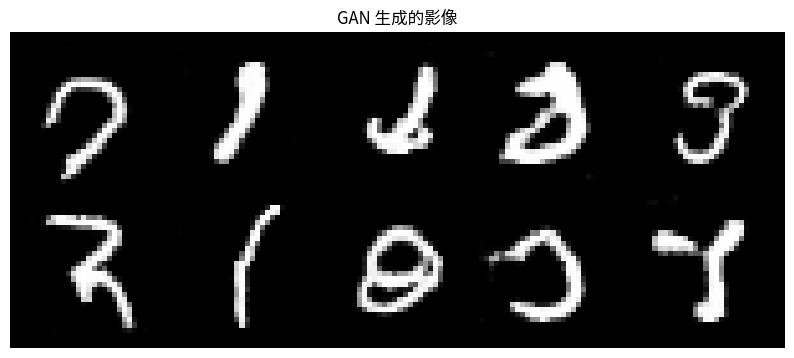

In [ ]:
# GAN 模型 - 升級為 CNN 版本
class GeneratorGAN(nn.Module):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256 * 7 * 7),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class DiscriminatorGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 初始化
generator_gan = GeneratorGAN().to(device)
discriminator_gan = DiscriminatorGAN().to(device)
optimizer_g = optim.Adam(generator_gan.parameters(), lr=lr_gan, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator_gan.parameters(), lr=lr_gan, betas=(beta1, 0.999))
criterion = nn.BCELoss()

print("訓練 GAN...")
for epoch in range(epochs_gan):
    for i, (images, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        real = torch.ones(images.size(0), 1).to(device)
        fake = torch.zeros(images.size(0), 1).to(device)

        # 訓練判別器
        optimizer_d.zero_grad()
        output_real = discriminator_gan(images)
        loss_real = criterion(output_real, real)
        z = torch.randn(images.size(0), noise_dim).to(device)
        fake_images = generator_gan(z)
        output_fake = discriminator_gan(fake_images.detach())
        loss_fake = criterion(output_fake, fake)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # 訓練生成器
        optimizer_g.zero_grad()
        output_fake = discriminator_gan(fake_images)
        loss_g = criterion(output_fake, real)
        loss_g.backward()
        optimizer_g.step()

    print(f"GAN Epoch {epoch+1}/{epochs_gan}, D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}")

# 生成 GAN 影像
with torch.no_grad():
    z = torch.randn(10, noise_dim).to(device)
    gan_samples = generator_gan(z)
show_images(gan_samples, "GAN 生成的影像", nrow=5)

# cGAN

訓練 cGAN...


100%|██████████| 375/375 [00:12<00:00, 31.20it/s]


cGAN Epoch 1/100, D Loss: 1.3589, G Loss: 0.7989


100%|██████████| 375/375 [00:11<00:00, 31.30it/s]


cGAN Epoch 2/100, D Loss: 1.3874, G Loss: 0.8363


100%|██████████| 375/375 [00:11<00:00, 31.31it/s]


cGAN Epoch 3/100, D Loss: 1.3401, G Loss: 0.8294


100%|██████████| 375/375 [00:12<00:00, 30.86it/s]


cGAN Epoch 4/100, D Loss: 1.3086, G Loss: 0.9076


100%|██████████| 375/375 [00:11<00:00, 31.46it/s]


cGAN Epoch 5/100, D Loss: 1.2102, G Loss: 0.9226


100%|██████████| 375/375 [00:12<00:00, 31.22it/s]


cGAN Epoch 6/100, D Loss: 1.3365, G Loss: 0.8209


100%|██████████| 375/375 [00:12<00:00, 31.18it/s]


cGAN Epoch 7/100, D Loss: 1.3010, G Loss: 0.8540


100%|██████████| 375/375 [00:11<00:00, 31.26it/s]


cGAN Epoch 8/100, D Loss: 1.2670, G Loss: 0.8740


100%|██████████| 375/375 [00:12<00:00, 31.00it/s]


cGAN Epoch 9/100, D Loss: 1.3069, G Loss: 0.8452


100%|██████████| 375/375 [00:11<00:00, 31.31it/s]


cGAN Epoch 10/100, D Loss: 1.2407, G Loss: 1.1528


100%|██████████| 375/375 [00:11<00:00, 31.40it/s]


cGAN Epoch 11/100, D Loss: 1.2214, G Loss: 0.9148


100%|██████████| 375/375 [00:12<00:00, 31.09it/s]


cGAN Epoch 12/100, D Loss: 1.4150, G Loss: 0.7334


100%|██████████| 375/375 [00:12<00:00, 31.19it/s]


cGAN Epoch 13/100, D Loss: 1.2326, G Loss: 0.9605


100%|██████████| 375/375 [00:12<00:00, 29.54it/s]


cGAN Epoch 14/100, D Loss: 1.2596, G Loss: 0.9347


100%|██████████| 375/375 [00:11<00:00, 31.35it/s]


cGAN Epoch 15/100, D Loss: 1.1532, G Loss: 1.2087


100%|██████████| 375/375 [00:12<00:00, 30.97it/s]


cGAN Epoch 16/100, D Loss: 1.3090, G Loss: 0.9404


100%|██████████| 375/375 [00:12<00:00, 31.18it/s]


cGAN Epoch 17/100, D Loss: 1.3434, G Loss: 0.9339


100%|██████████| 375/375 [00:12<00:00, 31.16it/s]


cGAN Epoch 18/100, D Loss: 1.4179, G Loss: 1.0363


100%|██████████| 375/375 [00:12<00:00, 30.99it/s]


cGAN Epoch 19/100, D Loss: 1.1347, G Loss: 1.3171


100%|██████████| 375/375 [00:12<00:00, 31.24it/s]


cGAN Epoch 20/100, D Loss: 1.1371, G Loss: 1.0631


100%|██████████| 375/375 [00:12<00:00, 31.08it/s]


cGAN Epoch 21/100, D Loss: 1.2639, G Loss: 1.0908


100%|██████████| 375/375 [00:12<00:00, 31.21it/s]


cGAN Epoch 22/100, D Loss: 1.2182, G Loss: 1.0406


100%|██████████| 375/375 [00:11<00:00, 31.48it/s]


cGAN Epoch 23/100, D Loss: 1.3448, G Loss: 0.9137


100%|██████████| 375/375 [00:12<00:00, 30.82it/s]


cGAN Epoch 24/100, D Loss: 1.1067, G Loss: 1.2733


100%|██████████| 375/375 [00:12<00:00, 30.95it/s]


cGAN Epoch 25/100, D Loss: 1.1895, G Loss: 0.9020


100%|██████████| 375/375 [00:12<00:00, 31.06it/s]


cGAN Epoch 26/100, D Loss: 1.2711, G Loss: 0.9649


100%|██████████| 375/375 [00:12<00:00, 31.00it/s]


cGAN Epoch 27/100, D Loss: 1.4395, G Loss: 1.0741


100%|██████████| 375/375 [00:11<00:00, 31.44it/s]


cGAN Epoch 28/100, D Loss: 1.3491, G Loss: 0.9285


100%|██████████| 375/375 [00:11<00:00, 31.25it/s]


cGAN Epoch 29/100, D Loss: 1.2715, G Loss: 0.8893


100%|██████████| 375/375 [00:12<00:00, 30.94it/s]


cGAN Epoch 30/100, D Loss: 1.1772, G Loss: 1.1477


100%|██████████| 375/375 [00:12<00:00, 30.75it/s]


cGAN Epoch 31/100, D Loss: 1.1226, G Loss: 1.2229


100%|██████████| 375/375 [00:12<00:00, 29.40it/s]


cGAN Epoch 32/100, D Loss: 1.0702, G Loss: 1.1602


100%|██████████| 375/375 [00:11<00:00, 31.31it/s]


cGAN Epoch 33/100, D Loss: 1.2511, G Loss: 0.8870


100%|██████████| 375/375 [00:12<00:00, 30.87it/s]


cGAN Epoch 34/100, D Loss: 0.9684, G Loss: 1.1122


100%|██████████| 375/375 [00:12<00:00, 31.09it/s]


cGAN Epoch 35/100, D Loss: 1.1851, G Loss: 0.9603


100%|██████████| 375/375 [00:11<00:00, 31.38it/s]


cGAN Epoch 36/100, D Loss: 0.9990, G Loss: 1.1211


100%|██████████| 375/375 [00:11<00:00, 31.26it/s]


cGAN Epoch 37/100, D Loss: 1.1545, G Loss: 0.9126


100%|██████████| 375/375 [00:11<00:00, 31.57it/s]


cGAN Epoch 38/100, D Loss: 0.9662, G Loss: 1.3294


100%|██████████| 375/375 [00:11<00:00, 31.34it/s]


cGAN Epoch 39/100, D Loss: 1.1833, G Loss: 1.3852


100%|██████████| 375/375 [00:12<00:00, 31.08it/s]


cGAN Epoch 40/100, D Loss: 1.2051, G Loss: 0.8741


100%|██████████| 375/375 [00:12<00:00, 30.90it/s]


cGAN Epoch 41/100, D Loss: 1.1892, G Loss: 1.0282


100%|██████████| 375/375 [00:12<00:00, 30.97it/s]


cGAN Epoch 42/100, D Loss: 1.0979, G Loss: 1.1286


100%|██████████| 375/375 [00:12<00:00, 30.83it/s]


cGAN Epoch 43/100, D Loss: 1.0701, G Loss: 1.1561


100%|██████████| 375/375 [00:12<00:00, 31.07it/s]


cGAN Epoch 44/100, D Loss: 1.2591, G Loss: 1.4302


100%|██████████| 375/375 [00:12<00:00, 30.93it/s]


cGAN Epoch 45/100, D Loss: 0.9557, G Loss: 1.3453


100%|██████████| 375/375 [00:12<00:00, 31.12it/s]


cGAN Epoch 46/100, D Loss: 1.3079, G Loss: 0.8239


100%|██████████| 375/375 [00:12<00:00, 31.15it/s]


cGAN Epoch 47/100, D Loss: 1.1284, G Loss: 1.0545


100%|██████████| 375/375 [00:12<00:00, 31.18it/s]


cGAN Epoch 48/100, D Loss: 1.2328, G Loss: 1.2143


100%|██████████| 375/375 [00:12<00:00, 29.48it/s]


cGAN Epoch 49/100, D Loss: 1.1003, G Loss: 1.2080


100%|██████████| 375/375 [00:12<00:00, 31.08it/s]


cGAN Epoch 50/100, D Loss: 1.1088, G Loss: 0.9924


100%|██████████| 375/375 [00:12<00:00, 30.85it/s]


cGAN Epoch 51/100, D Loss: 1.1097, G Loss: 1.0973


100%|██████████| 375/375 [00:12<00:00, 31.24it/s]


cGAN Epoch 52/100, D Loss: 1.1821, G Loss: 1.0822


100%|██████████| 375/375 [00:12<00:00, 31.16it/s]


cGAN Epoch 53/100, D Loss: 0.9868, G Loss: 1.1648


100%|██████████| 375/375 [00:12<00:00, 31.06it/s]


cGAN Epoch 54/100, D Loss: 1.1731, G Loss: 1.4456


100%|██████████| 375/375 [00:12<00:00, 31.11it/s]


cGAN Epoch 55/100, D Loss: 0.9644, G Loss: 1.2417


100%|██████████| 375/375 [00:12<00:00, 30.94it/s]


cGAN Epoch 56/100, D Loss: 1.0480, G Loss: 1.2306


100%|██████████| 375/375 [00:12<00:00, 30.70it/s]


cGAN Epoch 57/100, D Loss: 1.1213, G Loss: 1.1355


100%|██████████| 375/375 [00:12<00:00, 30.61it/s]


cGAN Epoch 58/100, D Loss: 0.9792, G Loss: 1.1805


100%|██████████| 375/375 [00:12<00:00, 31.07it/s]


cGAN Epoch 59/100, D Loss: 1.3394, G Loss: 1.4336


100%|██████████| 375/375 [00:12<00:00, 30.90it/s]


cGAN Epoch 60/100, D Loss: 1.2141, G Loss: 1.1539


100%|██████████| 375/375 [00:12<00:00, 30.93it/s]


cGAN Epoch 61/100, D Loss: 1.2872, G Loss: 0.9125


100%|██████████| 375/375 [00:12<00:00, 30.74it/s]


cGAN Epoch 62/100, D Loss: 1.0566, G Loss: 1.0922


100%|██████████| 375/375 [00:12<00:00, 30.70it/s]


cGAN Epoch 63/100, D Loss: 0.8969, G Loss: 1.3361


100%|██████████| 375/375 [00:12<00:00, 30.90it/s]


cGAN Epoch 64/100, D Loss: 0.9242, G Loss: 1.6126


100%|██████████| 375/375 [00:12<00:00, 31.07it/s]


cGAN Epoch 65/100, D Loss: 1.0078, G Loss: 1.1122


100%|██████████| 375/375 [00:11<00:00, 31.32it/s]


cGAN Epoch 66/100, D Loss: 1.1122, G Loss: 1.1157


100%|██████████| 375/375 [00:12<00:00, 28.89it/s]


cGAN Epoch 67/100, D Loss: 0.8115, G Loss: 1.6457


100%|██████████| 375/375 [00:12<00:00, 30.53it/s]


cGAN Epoch 68/100, D Loss: 0.9043, G Loss: 1.5096


100%|██████████| 375/375 [00:12<00:00, 30.78it/s]


cGAN Epoch 69/100, D Loss: 1.0029, G Loss: 1.1594


100%|██████████| 375/375 [00:12<00:00, 30.69it/s]


cGAN Epoch 70/100, D Loss: 1.2078, G Loss: 1.2674


100%|██████████| 375/375 [00:12<00:00, 30.85it/s]


cGAN Epoch 71/100, D Loss: 0.9421, G Loss: 1.3402


100%|██████████| 375/375 [00:12<00:00, 30.77it/s]


cGAN Epoch 72/100, D Loss: 0.9350, G Loss: 1.5480


100%|██████████| 375/375 [00:12<00:00, 30.39it/s]


cGAN Epoch 73/100, D Loss: 0.9555, G Loss: 1.6667


100%|██████████| 375/375 [00:12<00:00, 30.61it/s]


cGAN Epoch 74/100, D Loss: 1.1504, G Loss: 0.9782


100%|██████████| 375/375 [00:12<00:00, 30.52it/s]


cGAN Epoch 75/100, D Loss: 1.0616, G Loss: 1.4583


100%|██████████| 375/375 [00:12<00:00, 30.55it/s]


cGAN Epoch 76/100, D Loss: 1.0713, G Loss: 1.3123


100%|██████████| 375/375 [00:12<00:00, 30.39it/s]


cGAN Epoch 77/100, D Loss: 0.9696, G Loss: 1.3652


100%|██████████| 375/375 [00:12<00:00, 30.32it/s]


cGAN Epoch 78/100, D Loss: 1.0195, G Loss: 1.4248


100%|██████████| 375/375 [00:12<00:00, 30.51it/s]


cGAN Epoch 79/100, D Loss: 0.8703, G Loss: 1.3322


100%|██████████| 375/375 [00:12<00:00, 30.48it/s]


cGAN Epoch 80/100, D Loss: 1.2871, G Loss: 1.5278


100%|██████████| 375/375 [00:12<00:00, 30.68it/s]


cGAN Epoch 81/100, D Loss: 1.0473, G Loss: 1.3496


100%|██████████| 375/375 [00:12<00:00, 30.55it/s]


cGAN Epoch 82/100, D Loss: 0.9596, G Loss: 1.7408


100%|██████████| 375/375 [00:12<00:00, 30.33it/s]


cGAN Epoch 83/100, D Loss: 1.0591, G Loss: 1.3932


100%|██████████| 375/375 [00:12<00:00, 30.80it/s]


cGAN Epoch 84/100, D Loss: 1.0832, G Loss: 1.2136


100%|██████████| 375/375 [00:13<00:00, 28.74it/s]


cGAN Epoch 85/100, D Loss: 0.9633, G Loss: 1.4443


100%|██████████| 375/375 [00:12<00:00, 30.68it/s]


cGAN Epoch 86/100, D Loss: 1.0497, G Loss: 1.0479


100%|██████████| 375/375 [00:12<00:00, 30.78it/s]


cGAN Epoch 87/100, D Loss: 1.4043, G Loss: 0.8750


100%|██████████| 375/375 [00:12<00:00, 30.31it/s]


cGAN Epoch 88/100, D Loss: 0.8696, G Loss: 1.4106


100%|██████████| 375/375 [00:12<00:00, 30.49it/s]


cGAN Epoch 89/100, D Loss: 0.9505, G Loss: 1.3303


100%|██████████| 375/375 [00:12<00:00, 30.58it/s]


cGAN Epoch 90/100, D Loss: 1.0408, G Loss: 1.1607


100%|██████████| 375/375 [00:12<00:00, 30.86it/s]


cGAN Epoch 91/100, D Loss: 0.9306, G Loss: 1.3009


100%|██████████| 375/375 [00:12<00:00, 30.72it/s]


cGAN Epoch 92/100, D Loss: 1.0541, G Loss: 1.7257


100%|██████████| 375/375 [00:12<00:00, 30.54it/s]


cGAN Epoch 93/100, D Loss: 0.9693, G Loss: 1.2632


100%|██████████| 375/375 [00:12<00:00, 30.73it/s]


cGAN Epoch 94/100, D Loss: 1.0791, G Loss: 1.3693


100%|██████████| 375/375 [00:12<00:00, 31.19it/s]


cGAN Epoch 95/100, D Loss: 0.9956, G Loss: 1.1657


100%|██████████| 375/375 [00:12<00:00, 31.06it/s]


cGAN Epoch 96/100, D Loss: 1.0299, G Loss: 1.2175


100%|██████████| 375/375 [00:12<00:00, 30.83it/s]


cGAN Epoch 97/100, D Loss: 1.1602, G Loss: 1.8985


100%|██████████| 375/375 [00:12<00:00, 31.04it/s]


cGAN Epoch 98/100, D Loss: 1.0986, G Loss: 1.4346


100%|██████████| 375/375 [00:12<00:00, 30.83it/s]


cGAN Epoch 99/100, D Loss: 1.0293, G Loss: 1.3181


100%|██████████| 375/375 [00:12<00:00, 30.47it/s]


cGAN Epoch 100/100, D Loss: 0.9568, G Loss: 1.7084


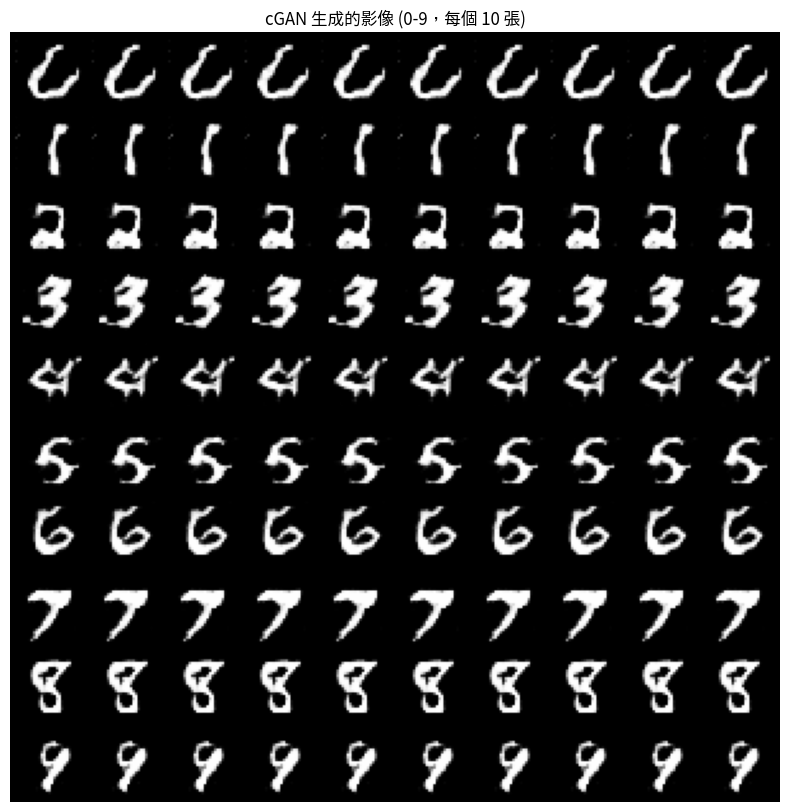

In [ ]:
# cGAN 模型 - 升級為 CNN 版本
class GeneratorCGAN(nn.Module):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        self.label_emb = nn.Embedding(num_classes, noise_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim * 2, 256 * 7 * 7),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        emb = self.label_emb(labels)
        input = torch.cat((z, emb), dim=1)
        return self.model(input)

class DiscriminatorCGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 28 * 28)
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        emb = self.label_emb(labels).view(labels.size(0), 1, 28, 28)
        input = torch.cat((x, emb), dim=1)
        return self.model(input)

# 初始化
generator_cgan = GeneratorCGAN().to(device)
discriminator_cgan = DiscriminatorCGAN().to(device)
optimizer_g_c = optim.Adam(generator_cgan.parameters(), lr=lr_cgan, betas=(beta1, 0.999))
optimizer_d_c = optim.Adam(discriminator_cgan.parameters(), lr=lr_cgan, betas=(beta1, 0.999))

print("訓練 cGAN...")
for epoch in range(epochs_cgan):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        real = torch.ones(images.size(0), 1).to(device) * 0.9  # 標籤平滑
        fake = torch.zeros(images.size(0), 1).to(device)

        # 訓練判別器
        optimizer_d_c.zero_grad()
        output_real = discriminator_cgan(images, labels)
        loss_real = criterion(output_real, real)
        z = torch.randn(images.size(0), noise_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (images.size(0),)).to(device)
        fake_images = generator_cgan(z, fake_labels)
        output_fake = discriminator_cgan(fake_images.detach(), fake_labels)
        loss_fake = criterion(output_fake, fake)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d_c.step()

        # 訓練生成器
        optimizer_g_c.zero_grad()
        output_fake = discriminator_cgan(fake_images, fake_labels)
        loss_g = criterion(output_fake, real)
        loss_g.backward()
        optimizer_g_c.step()

    print(f"cGAN Epoch {epoch+1}/{epochs_cgan}, D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}")

# 生成 cGAN 影像：每個類別 10 張，10x10 格
with torch.no_grad():
    z = torch.randn(100, noise_dim).to(device)
    labels = torch.cat([torch.full((10,), i, dtype=torch.long) for i in range(10)]).to(device)
    cgan_samples = generator_cgan(z, labels)
show_images(cgan_samples, "cGAN 生成的影像 (0-9，每個 10 張)", nrow=10)

# Diffusion Model

訓練 Diffusion 模型...


100%|██████████| 375/375 [00:47<00:00,  7.92it/s]


Diffusion Epoch 1/150, Loss: 0.0009 | Val: 0.0005 | Time: 52.47s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


Diffusion Epoch 2/150, Loss: 0.0005 | Val: 0.0004 | Time: 51.78s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


Diffusion Epoch 3/150, Loss: 0.0004 | Val: 0.0004 | Time: 51.68s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


Diffusion Epoch 4/150, Loss: 0.0004 | Val: 0.0004 | Time: 51.54s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Diffusion Epoch 5/150, Loss: 0.0004 | Val: 0.0004 | Time: 51.71s


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 6/150, Loss: 0.0004 | Val: 0.0004 | Time: 51.87s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


Diffusion Epoch 7/150, Loss: 0.0004 | Val: 0.0004 | Time: 51.69s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 8/150, Loss: 0.0004 | Val: 0.0003 | Time: 51.57s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


Diffusion Epoch 9/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.63s


100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


Diffusion Epoch 10/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.98s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


Diffusion Epoch 11/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.41s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


Diffusion Epoch 12/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.49s


100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


Diffusion Epoch 13/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.91s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 14/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.81s


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 15/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.52s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 16/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.59s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


Diffusion Epoch 17/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.86s


100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


Diffusion Epoch 18/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.80s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 19/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.55s


100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


Diffusion Epoch 20/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.76s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


Diffusion Epoch 21/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.64s


100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


Diffusion Epoch 22/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.59s


100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Diffusion Epoch 23/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.70s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


Diffusion Epoch 24/150, Loss: 0.0003 | Val: 0.0003 | Time: 52.08s
儲存最佳模型


100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Diffusion Epoch 25/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.85s


100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


Diffusion Epoch 26/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.75s


100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Diffusion Epoch 27/150, Loss: 0.0003 | Val: 0.0003 | Time: 52.29s


100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


Diffusion Epoch 28/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.66s


100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


Diffusion Epoch 29/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.78s


100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


Diffusion Epoch 30/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.61s


100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


Diffusion Epoch 31/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.96s


100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Diffusion Epoch 32/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.95s


100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


Diffusion Epoch 33/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.55s


100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


Diffusion Epoch 34/150, Loss: 0.0003 | Val: 0.0003 | Time: 51.69s
早停觸發
總訓練時間: 1760.37s


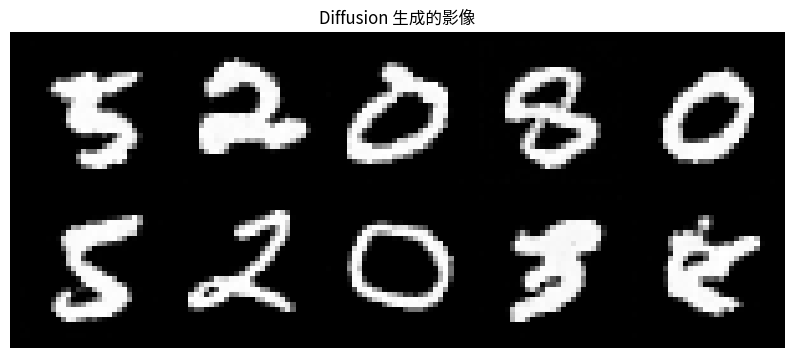

In [ ]:
# Diffusion 超參數
timesteps = 300
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def extract(a, t, x_shape):
    b = t.shape[0]
    out = a.gather(-1, t).reshape(b, *((1,) * (len(x_shape) - 1)))
    return out

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    return extract(sqrt_alphas_cumprod, t, x0.shape) * x0 + extract(sqrt_one_minus_alphas_cumprod, t, x0.shape) * noise

# Diffusion 模型
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(np.log(1.0), np.log(10000.0), steps=half, device=device)
        )
        args = t[:, None].float() * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_ch))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h += self.mlp(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.res_conv(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, t_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(t_emb_dim), nn.Linear(t_emb_dim, t_emb_dim*4), nn.SiLU(),
            nn.Linear(t_emb_dim*4, t_emb_dim)
        )
        # down
        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, 1, 1)
        self.rb1 = ResBlock(base_ch, base_ch, t_emb_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, 2, 1)  # 28->14
        self.rb2 = ResBlock(base_ch*2, base_ch*2, t_emb_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, 2, 1)  # 14->7
        self.rb3 = ResBlock(base_ch*4, base_ch*4, t_emb_dim)
        # bottleneck
        self.rb_mid = ResBlock(base_ch*4, base_ch*4, t_emb_dim)
        # up
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, 2, 1)  # 7->14
        self.rb4 = ResBlock(base_ch*4, base_ch*2, t_emb_dim)
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, 2, 1)    # 14->28
        self.rb5 = ResBlock(base_ch*2, base_ch, t_emb_dim)
        self.conv_out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h1 = self.conv_in(x); h1 = self.rb1(h1, t_emb)
        h2 = self.down1(h1);  h2 = self.rb2(h2, t_emb)
        h3 = self.down2(h2);  h3 = self.rb3(h3, t_emb)
        h  = self.rb_mid(h3, t_emb)
        h  = self.up1(h);     h  = torch.cat([h, h2], dim=1); h = self.rb4(h, t_emb)
        h  = self.up2(h);     h  = torch.cat([h, h1], dim=1); h = self.rb5(h, t_emb)
        out = self.conv_out(h)
        return out  # 預測噪音

# 初始化模型
model_diff = TinyUNet(in_ch=channels, base_ch=64, t_emb_dim=128).to(device)
optimizer_diff = optim.Adam(model_diff.parameters(), lr=lr_diffusion)
criterion_diff = nn.MSELoss()

# 訓練 Diffusion
def diffusion_loss_batch(x0):
    b = x0.size(0)
    t = torch.randint(0, timesteps, (b,), device=device).long()
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    predicted_noise = model_diff(xt, t)
    loss = criterion_diff(predicted_noise, noise)
    return loss

best_val = float('inf')
early = 0
best_model_path = "diffusion_best.pth"
train_losses, valid_losses = [], []

print("訓練 Diffusion 模型...")
total_start = time.time()
for epoch in range(1, epochs_diffusion + 1):
    ep_start = time.time()
    model_diff.train()
    train_loss_sum = 0.0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        loss = diffusion_loss_batch(data)
        optimizer_diff.zero_grad()
        loss.backward()
        optimizer_diff.step()
        train_loss_sum += loss.item()
    avg_train = train_loss_sum / len(train_loader.dataset)
    train_losses.append(avg_train)

    # validation
    model_diff.eval()
    val_sum = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            val_sum += diffusion_loss_batch(data).item()
    avg_val = val_sum / len(valid_loader.dataset)
    valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"Diffusion Epoch {epoch}/{epochs_diffusion}, Loss: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(model_diff.state_dict(), best_model_path)
        print("儲存最佳模型")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("早停觸發")
            break

total_time = time.time() - total_start
print(f"總訓練時間: {total_time:.2f}s")

# Diffusion 取樣
@torch.no_grad()
def sample_diffusion(num_samples):
    model_diff.eval()
    x = torch.randn(num_samples, channels, image_size, image_size).to(device)
    for t in reversed(range(timesteps)):
        t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
        predicted_noise = model_diff(x, t_tensor)
        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        alpha = alpha.expand(num_samples, channels, image_size, image_size)
        alpha_cumprod = alpha_cumprod.expand(num_samples, channels, image_size, image_size)
        beta = beta.expand(num_samples, channels, image_size, image_size)
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise) + torch.sqrt(beta) * noise
    return x.clamp(-1, 1)

diff_samples = sample_diffusion(10)
show_images(diff_samples, "Diffusion 生成的影像", nrow=5)

# 比較

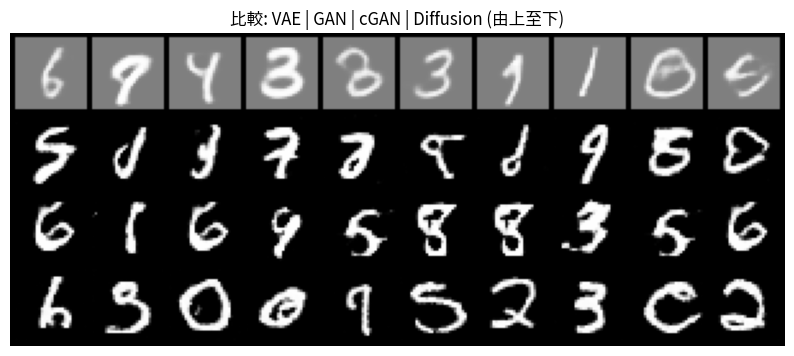

In [ ]:
# 比較
# 生成比較用的影像（每個模型隨機 10 張）
with torch.no_grad():
    z_vae = torch.randn(10, latent_dim).to(device)
    vae_comp = vae.decode(z_vae)

    z_gan = torch.randn(10, noise_dim).to(device)
    gan_comp = generator_gan(z_gan)

    z_cgan = torch.randn(10, noise_dim).to(device)
    labels_cgan = torch.randint(0, num_classes, (10,)).to(device)
    cgan_comp = generator_cgan(z_cgan, labels_cgan)

    diff_comp = sample_diffusion(10)

# 繪製比較圖
comp_images = torch.cat([vae_comp, gan_comp, cgan_comp, diff_comp])
show_images(comp_images, "比較: VAE | GAN | cGAN | Diffusion (由上至下)", nrow=10)

# 注意：分析部分請觀察清晰度、穩定性（GAN 是否有模式崩潰）、可控性（cGAN 可指定類別）、效率（訓練/推理時間）。